<a href="https://colab.research.google.com/github/mirasmitty/Project_Zillow/blob/main/zillow_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zillow Price Reduction Prediction

In [ ]:
# Initial imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Loading data
df = pd.read_csv("https://raw.githubusercontent.com/mirasmitty/Project_Zillow/main/Resources/Zillow_data_Detroit.csv")
df['Week of pending'] = pd.to_datetime(df['Week of pending'])
df['Week of pending'] = df['Week of pending'].values.astype("int64")
df.head()

,Week of pending,Mean days listing to pending,Mean price reduction percentage
0,1517011200000000000,49,0.045619
1,1517616000000000000,48,0.046532
2,1518220800000000000,47,0.048536
3,1518825600000000000,46,0.049169
4,1519430400000000000,43,0.048168


## Loading and Preprocessing Loans Encoded Data

In [ ]:
df.dtypes

Week of pending                      int64
Mean days listing to pending         int64
Mean price reduction percentage    float64
dtype: object

In [ ]:
df.count()

Week of pending                    315
Mean days listing to pending       315
Mean price reduction percentage    313
dtype: int64

In [ ]:
df = df.dropna()
df.shape

(313, 3)

In [ ]:
# Define features set
x = df.drop("Mean price reduction percentage", axis=1)

x.head()

,Week of pending,Mean days listing to pending
0,1517011200000000000,49
1,1517616000000000000,48
2,1518220800000000000,47
3,1518825600000000000,46
4,1519430400000000000,43


In [ ]:
# Define target vector
y = df["Mean price reduction percentage"].ravel()
y[:5]

array([0.04561916, 0.04653246, 0.04853574, 0.04916884, 0.04816789])

In [ ]:
# Splitting into Train and Test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=78)


In [ ]:
# Creating StandardScaler instance

scaler = StandardScaler()



In [ ]:
# Fitting Standard Scaller
x_scaler = scaler.fit(x_train)

In [ ]:
# Scaling data
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

## Fitting the Random Forest Model

In [ ]:
# Create a random forest classifier
rf_model = RandomForestRegressor(n_estimators=500, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(x_train_scaled, y_train)

## Making Predictions Using the Random Forest Model

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(x_test_scaled)

In [ ]:
predictions.shape

## Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error


In [ ]:
# Compute the metrics for the Random forest regression model
score = rf_model.score(x_test, y_test,sample_weight=None)
r2 = r2_score(y_test,predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
std = np.std(y_test)
error = mean_absolute_error(y_test, predictions)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")
print(f"The error is {error} ")

The score is -0.0119782812235536.
The r2 is 0.9631252957181322.
The mean squared error is 7.693645740676662e-07.
The root mean squared error is 0.0008771342964835352.
The standard deviation is 0.004567744669218188.
The error is 0.0006462160741772377 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


## Feature Importance

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
imprtances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, x.columns), reverse= True)

[(0.9364761180389954, 'Week of pending'),
 (0.0635238819610046, 'Mean days listing to pending')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

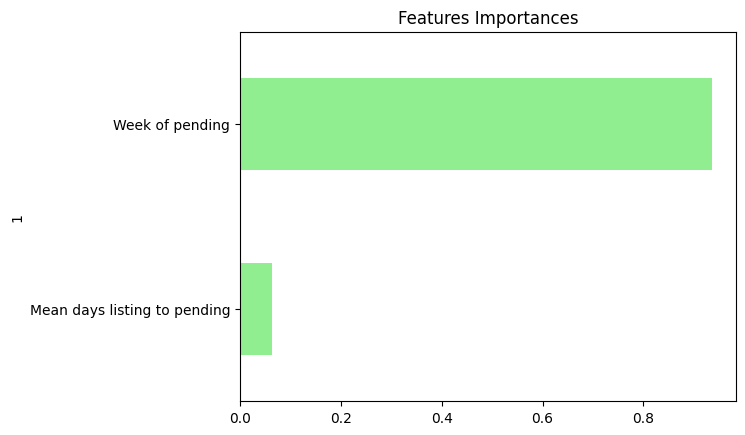

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, x.columns), reverse = True))
importances_df.set_index(importances_df[1], inplace = True)
importances_df.drop(columns = 1, inplace = True)
importances_df.rename(columns = {0: 'Feature Importances'}, inplace = True)
importances_sorted = importances_df.sort_values(by = 'Feature Importances')
importances_sorted.plot(kind = 'barh', color = 'lightgreen', title = 'Features Importances', legend = False)

In [ ]:
print("Shape")
print("Training data : ", df.shape)
print("Test data     : ", df.shape)

Shape
Training data :  (313, 3)
Test data     :  (313, 3)


In [ ]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

s = (df.dtypes == 'int')
num_cols = list(s[s].index)
print("Integer variables:")
print(num_cols)

s = (df.dtypes == 'float')
num_cols = list(s[s].index)
print("Real variables:")
print(num_cols)

Categorical variables:
[]
Integer variables:
['Week of pending', 'Mean days listing to pending']
Real variables:
['Mean price reduction percentage']


In [ ]:

import seaborn as sns
pd.set_option('display.max_rows', None)

<Axes: title={'center': 'Heatmap of missing values'}>

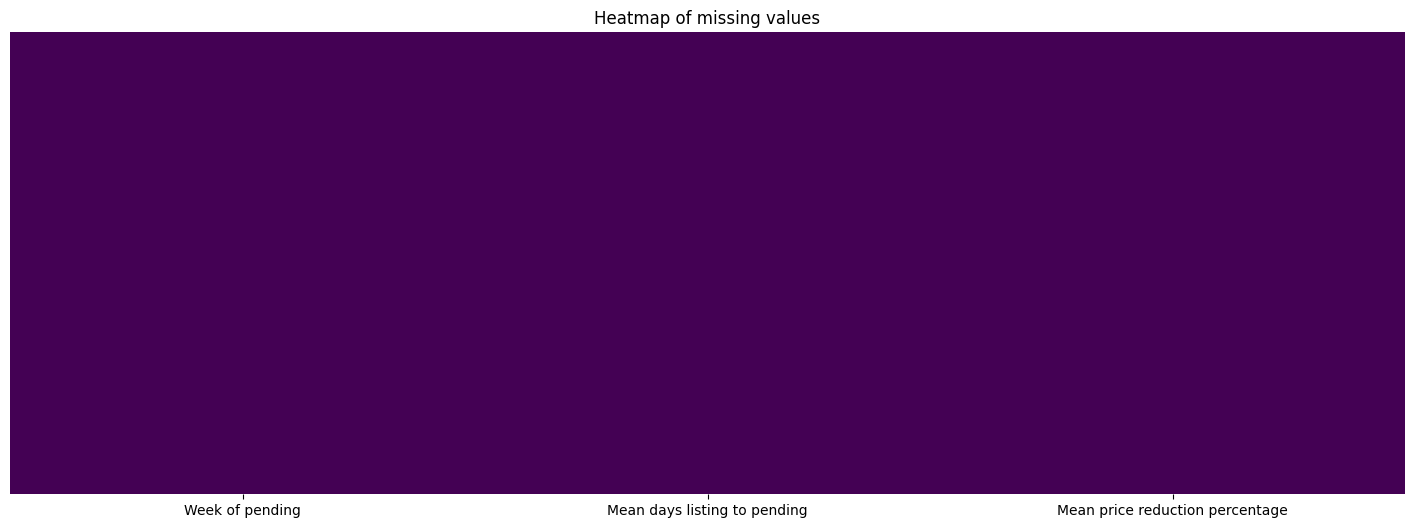

In [ ]:
plt.figure(figsize=(18,6))
plt.title('Heatmap of missing values')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
df.head()

##Check that all missing values have been taken care of.


In [ ]:
print(df.isnull().sum().sum())


0


#Data Preprocessing

###Import Onehot encoder to encode categorical features


In [ ]:
from sklearn.preprocessing import OneHotEncoder


In [ ]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',len(object_cols))

Categorical variables:
[]
No. of. categorical features:  0


In [ ]:

cat = df.dtypes[df.dtypes == "object"].index.tolist()

df[cat].nunique()

Series([], dtype: float64)

In [ ]:
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(cat)
encode_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


""
0
1
2
3
4


No charts were generated by quickchart


In [ ]:
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
OH_cols.index = df.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = df.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
df_final.head()

,Week of pending,Mean days listing to pending,Mean price reduction percentage
0,1517011200000000000,49,0.045619
1,1517616000000000000,48,0.046532
2,1518220800000000000,47,0.048536
3,1518825600000000000,46,0.049169
4,1519430400000000000,43,0.048168


In [ ]:
# Check that the shapes are consistent

print('df_final shape:', df_final.shape)
print('df_train shape:', df.shape)
print('df_test shape:',  df.shape)

X_Train = pd.DataFrame(df_final[:1460])
X_Test  = pd.DataFrame(df_final[1460:])
Y_Train = df['Mean price reduction percentage']

print('\nCheck that the datasets are consistent:\n')
print('X_train shape', X_Train.shape)
print('Y_train shape:', Y_Train.shape)
print('X_test shape:',  X_Test.shape)

df_final shape: (313, 3)
df_train shape: (313, 3)
df_test shape: (313, 3)

Check that the datasets are consistent:

X_train shape (313, 3)
Y_train shape: (313,)
X_test shape: (0, 3)


#Model selection and prediction


In [ ]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import train_test_split

# Split the training set into training and validation set

X_train, X_valid, Y_train, Y_valid = train_test_split(X_Train, Y_Train, train_size=0.8, test_size=0.2,random_state=0)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor()
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)
print(mean_absolute_error(Y_valid, Y_pred))

6.516779333333543e-05


In [ ]:
# Compute the metrics for the Random forest regression model
score = model_RFR.score(X_valid, Y_valid, sample_weight=None)
r2 = r2_score(Y_valid,Y_pred)
mse = mean_squared_error(Y_valid, Y_pred)
rmse = np.sqrt(mse)
std = np.std(Y_valid)
error = mean_absolute_error(Y_valid, Y_pred)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")
print(f"The error is {error} ")

The score is 0.9994242839318144.
The r2 is 0.9994242839318144.
The mean squared error is 1.6956099461299134e-08.
The root mean squared error is 0.00013021558839593336.
The standard deviation is 0.005426987263266367.
The error is 6.516779333333543e-05 


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, Y_train)
Y_pred = model_GBR.predict(X_valid)
print(mean_absolute_error(Y_valid, Y_pred))

6.301533430899643e-05


In [ ]:
# Compute the metrics for the GradientBoostingRegessor model
score = model_GBR.score(X_valid, Y_valid, sample_weight=None)
r2 = r2_score(Y_valid,Y_pred)
mse = mean_squared_error(Y_valid, Y_pred)
rmse = np.sqrt(mse)
std = np.std(Y_valid)
error = mean_absolute_error(Y_valid, Y_pred)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")
print(f"The error is {error} ")

The score is 0.9995449001208385.
The r2 is 0.9995449001208385.
The mean squared error is 1.3403688453939992e-08.
The root mean squared error is 0.00011577429962621234.
The standard deviation is 0.005426987263266367.
The error is 6.301533430899643e-05 


In [ ]:
from sklearn.linear_model import SGDRegressor

model_SGD = SGDRegressor()
model_SGD.fit(X_train, Y_train)
Y_pred = model_SGD.predict(X_valid)
print(mean_absolute_error(Y_valid, Y_pred))

1.6332533316637145e+45


In [ ]:
# Compute the metrics for the SGD Regressor model
score = model_SGD.score(X_valid, Y_valid, sample_weight=None)
r2 = r2_score(Y_valid,Y_pred)
mse = mean_squared_error(Y_valid, Y_pred)
rmse = np.sqrt(mse)
std = np.std(Y_valid)
error = mean_absolute_error(Y_valid, Y_pred)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")
print(f"The error is {error} ")

The score is -9.067324910179059e+94.
The r2 is -9.067324910179059e+94.
The mean squared error is 2.670525828980994e+90.
The root mean squared error is 1.6341743569708204e+45.
The standard deviation is 0.005426987263266367.
The error is 1.6332533316637145e+45 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor

model_XGBR = XGBRegressor(learning_rate=0.03,n_estimators=200,objective='reg:squarederror')
model_XGBR.fit(X_train,Y_train)
Y_pred = model_XGBR.predict(X_valid)
print(mean_absolute_error(Y_valid, Y_pred))

0.00013350071454126876


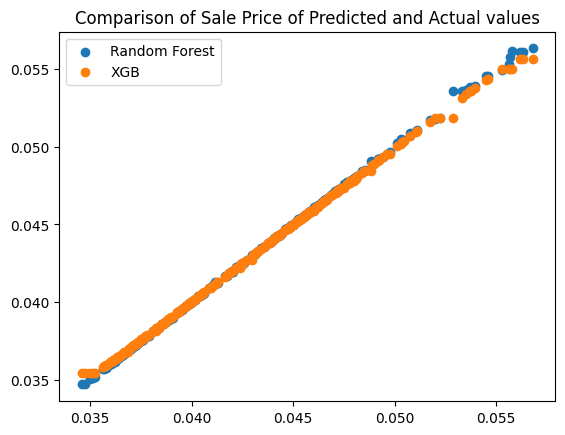

In [ ]:
plt.figure()
plt.title('Comparison of Sale Price of Predicted and Actual values')
plt.scatter(Y_Train,model_RFR.predict(X_Train),label='Random Forest')
plt.scatter(Y_Train,model_XGBR.predict(X_Train),label='XGB')
plt.legend()

In [ ]:
from sklearn.model_selection import GridSearchCV
model = XGBRegressor()

n_estimators   = [100, 200, 500]
learning_rates = [0.03,0.1,0.3]
objectives     = ['reg:squarederror']

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators' : n_estimators,
    'learning_rate':learning_rates,
    'objective' : objectives
    }

grid_cv = GridSearchCV(estimator = model,
            param_grid = hyperparameter_grid,
            scoring = 'neg_mean_absolute_error',
            return_train_score = True)

grid_cv.fit(X_Train,Y_Train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.03, 0.1, 0.3],
                         'n_estimators': [100, 200, 500],
                         'objective': ['reg:squarederror']},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
grid_cv.best_score_


-0.0004157505676174873

In [ ]:
grid_cv.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Y_pred = random_cv.predict(X_valid)
#print(mean_absolute_error(Y_valid, Y_pred))

In [ ]:
regressor = grid_cv.best_estimator_
Y_pred = regressor.predict(X_valid)
print(mean_absolute_error(Y_valid, Y_pred))

5.750898265057509e-05


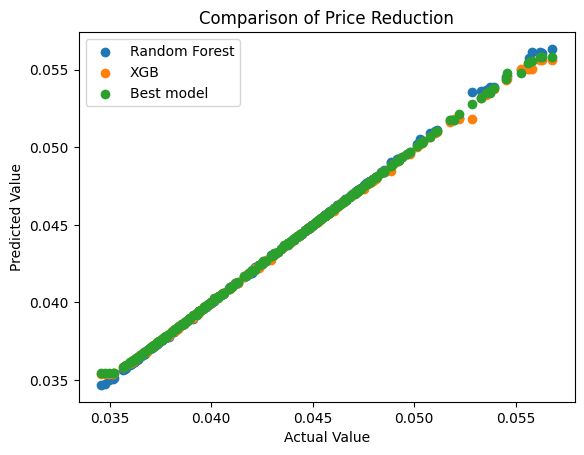

In [ ]:
plt.figure()
plt.title('Comparison of Price Reduction')
plt.scatter(Y_Train,model_RFR.predict(X_Train),label='Random Forest')
plt.scatter(Y_Train,model_XGBR.predict(X_Train),label='XGB')
plt.scatter(Y_Train,regressor.predict(X_Train),label='Best model')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.legend()


#Preparation of Submission Data

In [ ]:
#Y_Pred = regressor.predict(X_Test)


In [ ]:
#Y_Pred


In [ ]:
#Y_Pred.shape


In [ ]:
#sub = pd.DataFrame()
#sub['Mean days listing to pending'] = df['Mean days listing to pending']
#sub['Mean price reduction percentage'] = Y_Pred